### Загрузка необходимых библиотек:

In [1]:
# Основные фреймворки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализации
import matplotlib
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

In [3]:
# Импорт используемых фреймворков
from phik import phik_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

------------------

In [4]:
# Загрузка данных
df = pd.read_csv('sensor.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True).drop('Unnamed: 0', axis=1)
df.head(2)

# Временной диапазон 
start = df.index[0]
stop = df.index[-1]

# Выделим в отдельные переменные записи, которые не соответствуют статусу "NORMAL" 
df_broken = df[df.machine_status=='BROKEN']
df_recovering = df[df.machine_status=='RECOVERING']

# Статус машины для визуализации
status = pd.read_csv('y.csv',  index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
status['target'] = 0
status.target.loc[((status.machine_status=='NORMAL') | (status.machine_status=='RECOVERING'))] = 1

In [5]:
X = pd.read_csv('X.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
X_scaled = pd.read_csv('X_scaled.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
pca_res = pd.read_csv('pca_res1.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [6]:
# Функция для визуализации

def anomaly_visualisation(df, anomaly_columns):
    for sensor in df.columns[:9]:
        _ = plt.figure(figsize=(18,3))
        _ = plt.plot(df[sensor], color='grey', label='Data')
        _ = plt.plot(df.loc[df[anomaly_columns]==1][sensor], linestyle='none', color='r', marker ='.', markersize=2, alpha=.3, label = 'Forest Anomaly')
        _ = plt.plot(df_broken[sensor], linestyle='none', marker='o', color='black', markersize=10, label='BROKEN')
        _ = plt.title(sensor)
        _ = plt.plot(df[sensor].mean()*status.target, linestyle='--', color='orange')
        plt.xlim(start, stop) 
        plt.tight_layout()
    plt.legend(loc='upper right')   
    plt.show()

In [7]:
# Функция метрик

def metrics_report(test, pred):
    from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
    
    cm = confusion_matrix(test, pred)

    ax = sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], cmap='RdBu_r')
    ax.set_ylabel('TRUE')
    ax.set_xlabel('PREDICT')
    plt.show()
    
    print(classification_report(test, pred, digits=4))
    print(round(balanced_accuracy_score(test, pred), 4))
    return

Оценка обнаружения аномалий представляет сложную задачу из-за отсутствия размеченной выборки. Поэтому задачу обучения без учителя стараются свести к обучению с учителем, при помощи введения синтетических аномалий.

Так как задача состоит в определении аномалий раньше сбоя (за 24 ча-са), то в качестве размеченных данных создадим синтетические аномалии, так что отклонениями считаются наблюдения за 24 часа до сбоя, отмеченного в признаке «machine_status».


In [8]:
# Синтетические аномалии

from datetime import datetime, timedelta

sint_anomaly = df.machine_status
for day_broken in df_broken.index:
    result_date = day_broken - timedelta(days=1)
    sint_anomaly.loc[result_date:day_broken] = 1
    
sint_anomaly.loc[(sint_anomaly=='BROKEN') | (sint_anomaly=='RECOVERING')] = 1
sint_anomaly.loc[sint_anomaly=='NORMAL'] = 0
sint_anomaly = sint_anomaly.astype('int')
sint_anomaly.value_counts()

0    195756
1     24564
Name: machine_status, dtype: int64

### IQR

Подход представляет идею доверительного интервала, который равен диапазону, заключенному между границами.

In [9]:
def IQR_func(PC):
    # Функция рассчета межквартильного расстояния, верхней и нижней границы наблюдаемых значений
    
    q1, q3 = PC.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower = q1 - (1.5 * IQR)    # Нижняя граница
    upper = q3 + (1.5 * IQR)    # Верхняя граница
    return IQR, lower, upper

In [10]:
%%time
IQR_res = pd.DataFrame(0, columns=['IQR', 'lower', 'upper'], index = pca_res.columns)

for i in pca_res.columns:
    iqr_pca, lower_pca, upper_pca = IQR_func(pca_res[i])
    IQR_res.loc[i] = [iqr_pca, lower_pca, upper_pca]
    
IQR_res

Wall time: 24 ms


,IQR,lower,upper
PC0,1.123412,-3.543251,0.950395
PC1,1.762452,-2.835949,4.213857
PC2,1.260409,-2.693965,2.347670
PC3,2.437587,-4.969272,4.781076


In [11]:
%%time
# Количество аномалий (0 - не аномалия, 1 - аномалия)
for i in pca_res.columns:
    pca_res[f'anomaly_PC{i}'] = ((pca_res[i]>IQR_res.loc[i].upper) | (pca_res[i]<IQR_res.loc[i].lower)).astype(int)

Wall time: 16 ms


In [12]:
anomaly_columns = pca_res.columns[-4:]
for column in anomaly_columns:
    print(f' % {column}: {round(100 * len(pca_res.loc[pca_res[column]==1])/len(df), 3)}')

 % anomaly_PCPC0: 13.146
 % anomaly_PCPC1: 7.999
 % anomaly_PCPC2: 2.502
 % anomaly_PCPC3: 0.687


In [17]:
%%time
y_pred = pca_res['anomaly_PCPC0'] + pca_res['anomaly_PCPC1'] + pca_res['anomaly_PCPC2'] + pca_res['anomaly_PCPC3']
y_pred = (y_pred.astype('bool')).astype('int')
y_pred = pd.DataFrame(data=y_pred, columns=['Anomaly'])

Wall time: 36.6 ms


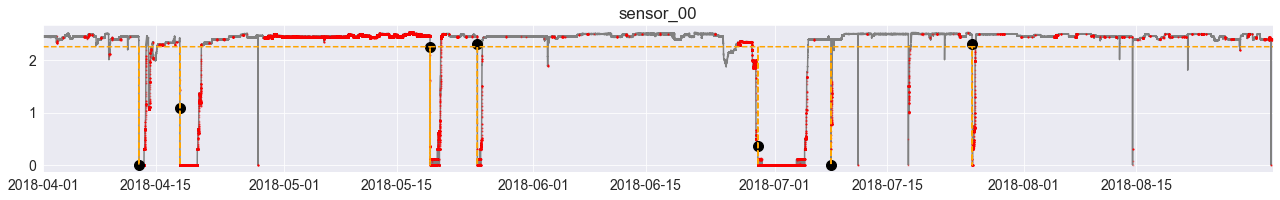

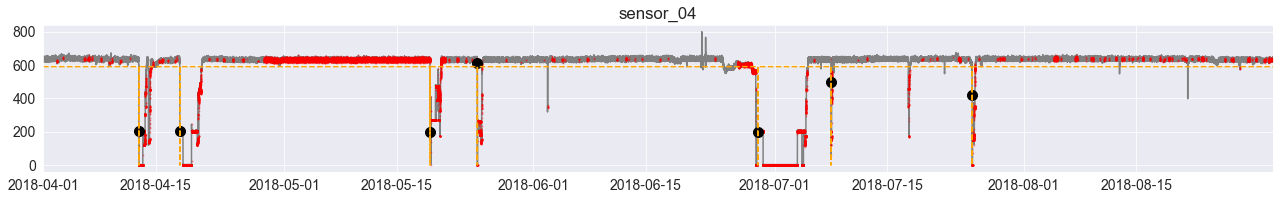

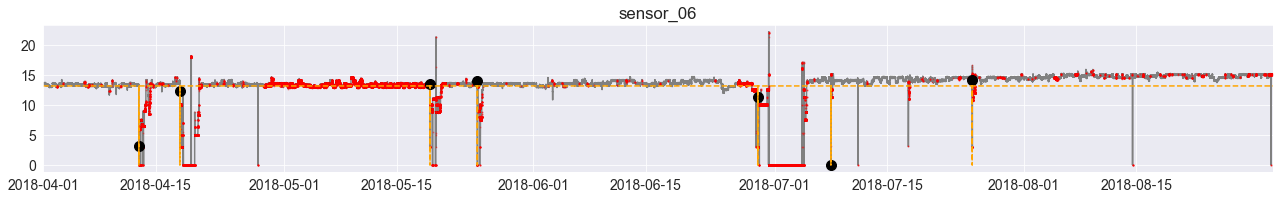

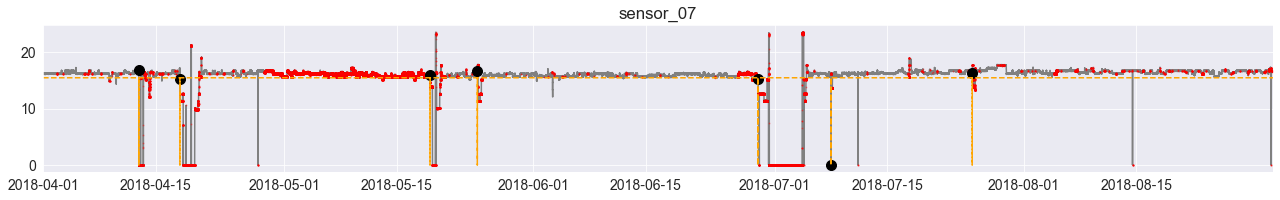

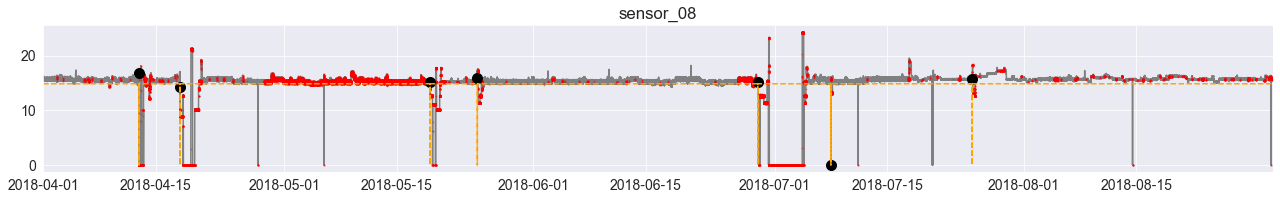

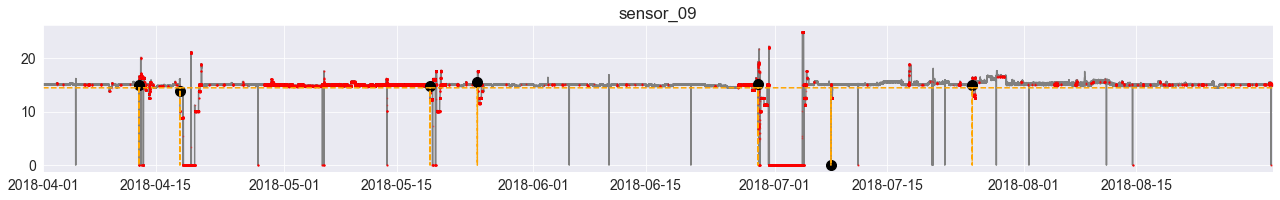

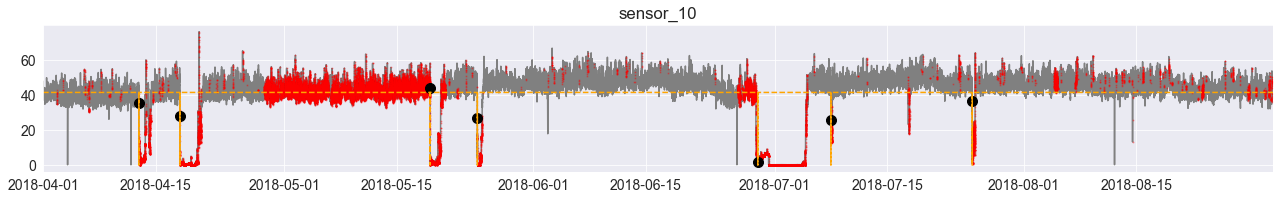

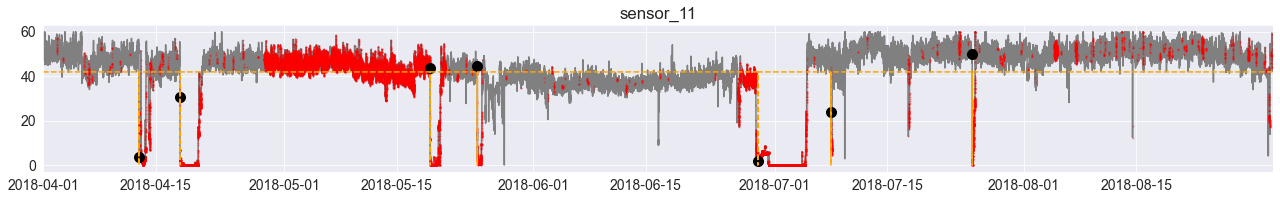

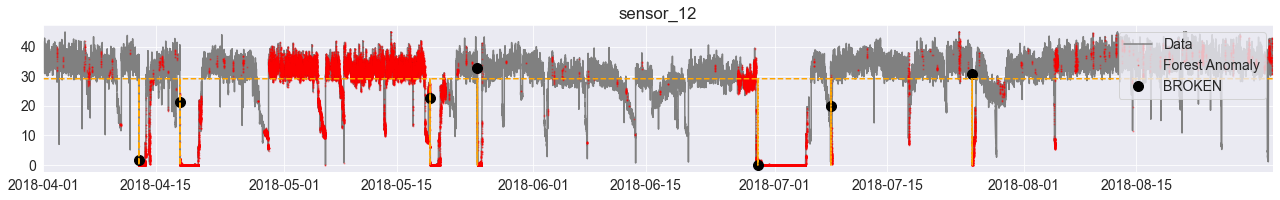

In [18]:
# Визуализация аномалий, обнаруженных при помощи метода IQR
pca_vis = pd.concat([X, y_pred], axis=1)
anomaly_visualisation(pca_vis, 'Anomaly')

По графикам видно, что обнаруженные аномалии при по-мощи метода межквартильных расстояний находятся перед точками "BROKEN". Наибольшая концентрация аномальных значений перед третьим отказом насоса. 

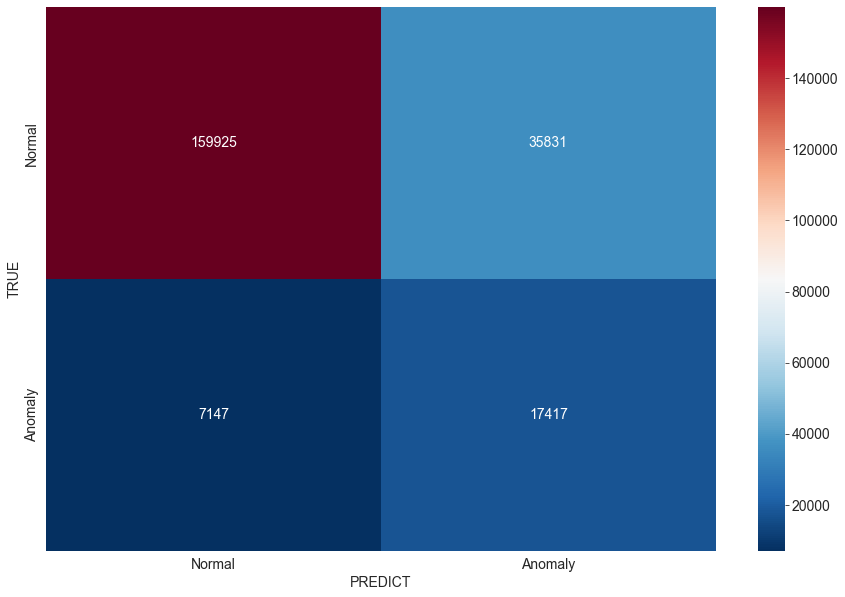

              precision    recall  f1-score   support

           0     0.9572    0.8170    0.8815    195756
           1     0.3271    0.7090    0.4477     24564

    accuracy                         0.8049    220320
   macro avg     0.6422    0.7630    0.6646    220320
weighted avg     0.8870    0.8049    0.8332    220320

0.763


In [19]:
metrics_report(sint_anomaly.values, y_pred)

В задаче предсказания аномалий больший акцент уделяют метрике recall, так как данный показатель показывает, насколько модель ведет себя «уверенно». То есть важнее не пропустить класс 1 (аномалии) и пожертвовать значением FP. Таким образом, необходимо минимизировать ошибку второго рода – FN.